# Part 2: CNN Classification

## Introduction

In this part, you'll implement a Convolutional Neural Network (CNN) for EMNIST character recognition. You can choose between TensorFlow/Keras or PyTorch for implementation. This will help you understand CNNs and their advantages for image classification tasks.

## Learning Objectives

- Implement a CNN using either TensorFlow/Keras or PyTorch
- Apply convolutional layers, pooling, and batch normalization
- Train and evaluate the model
- Save model and metrics in the correct format

## Setup and Installation


In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Set random seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# Configure matplotlib for better visualization
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

# Create directories
os.makedirs('models', exist_ok=True)
os.makedirs('results/part_2', exist_ok=True)
os.makedirs('logs', exist_ok=True)


2025-05-15 05:52:20.074883: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-15 05:52:20.082842: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-15 05:52:20.130384: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747288340.383096  109028 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747288340.485425  109028 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747288341.063726  109028 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

## 1. Data Loading and Preprocessing

2025-05-15 05:52:30.781034: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
2025-05-15 05:52:31.042642: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:387] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 8388608
2025-05-15 05:52:54.753907: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-05-15 05:52:58.856683: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


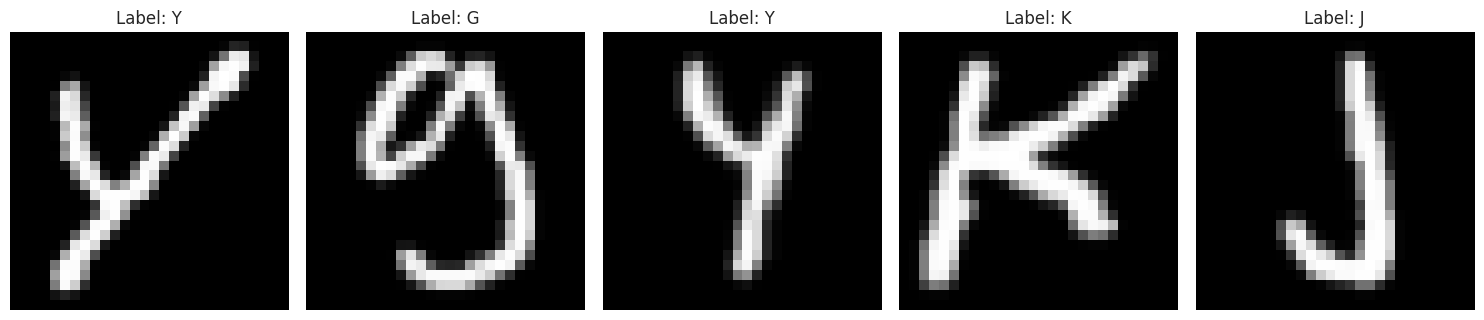

In [2]:
import tensorflow_datasets as tfds

# Load the dataset
(ds_train, ds_test), ds_info = tfds.load(
    'emnist/letters',
    split=['train', 'test'],
    as_supervised=True,
    with_info=True
)

# Convert to NumPy arrays
train_data = tfds.as_numpy(ds_train)
test_data = tfds.as_numpy(ds_test)

# Unpack the generator
x_train, y_train = zip(*train_data)
x_test, y_test = zip(*test_data)

# Convert from tuples to NumPy arrays
x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)

# Normalize the pixel values
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

plt.figure(figsize=(15, 5))

for i in range(5):
    plt.subplot(1, 5, i + 1)
    img = x_train[i].squeeze().T  # Remove channel dimension and transpose
    plt.imshow(img, cmap='gray')
    plt.title(f'Label: {chr(y_train[i] + 64)}')  # EMNIST letters are 1-26, A=65 in ASCII
    plt.axis('off')

plt.tight_layout()
plt.show()

In [3]:
# Preprocess data
# Normalize pixel values
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Reshape for CNN input (samples, height, width, channels)
x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

# Convert labels to one-hot encoding
y_train = tf.keras.utils.to_categorical(y_train - 1, num_classes=26)
y_test = tf.keras.utils.to_categorical(y_test - 1, num_classes=26)

# Split training data into train and validation
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(
    x_train, y_train, test_size=0.2, random_state=42
)

print(f"Preprocessed training data shape: {x_train.shape}")
print(f"Preprocessed validation data shape: {x_val.shape}")
print(f"Preprocessed test data shape: {x_test.shape}")


Preprocessed training data shape: (71040, 28, 28, 1)
Preprocessed validation data shape: (17760, 28, 28, 1)
Preprocessed test data shape: (14800, 28, 28, 1)


In [4]:
print(f"Preprocessed training data shape: {y_train.shape}")
print(f"Preprocessed validation data shape: {y_val.shape}")
print(f"Preprocessed test data shape: {y_test.shape}")

Preprocessed training data shape: (71040, 26)
Preprocessed validation data shape: (17760, 26)
Preprocessed test data shape: (14800, 26)


## 2. Model Implementation

### PyTorch Implementation


In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F


In [6]:
class CNN(nn.Module):
    def __init__(self, num_classes):
        """
        Create a CNN using PyTorch.
        
        Requirements:
        - Must use at least 2 convolutional layers
        - Must include pooling and batch normalization
        
        Goals:
        - Achieve > 85% accuracy on test set
        - Minimize overfitting using batch normalization and dropout
        - Train efficiently with appropriate batch size and learning rate
        
        Args:
            num_classes: Number of output classes (26 for letters)
        """
        super(CNN, self).__init__()

        self.conv_block1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.conv_block2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1), 
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.dropout = nn.Dropout(0.5)

        self.fc = nn.Sequential(
            nn.Linear(64 * 7 * 7, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )

    
    def forward(self, x):
        """
        Forward pass of the network.
        
        Args:
            x: Input tensor of shape (batch_size, channels, height, width)
        
        Returns:
            Output tensor of shape (batch_size, num_classes)
        """
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = x.reshape(x.size(0), -1)
        x = self.fc(x)
        return x

# Create model
model = CNN(num_classes=26)
print(model)


CNN(
  (conv_block1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Sequential(
    (0): Linear(in_features=3136, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=128, out_features=26, bias=True)
  )
)


## 3. Training and Evaluation

### Pytorch Training

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [8]:
# Convert data to PyTorch tensors
x_train = torch.FloatTensor(x_train).to(device)
y_train = torch.LongTensor(y_train).to(device)
x_val = torch.FloatTensor(x_val).to(device)
y_val = torch.LongTensor(y_val).to(device)

In [9]:
print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"x_val shape: {x_val.shape}")
print(f"y_val shape: {y_val.shape}")

x_train shape: torch.Size([71040, 28, 28, 1])
y_train shape: torch.Size([71040, 26])
x_val shape: torch.Size([17760, 28, 28, 1])
y_val shape: torch.Size([17760, 26])


In [10]:
x_train = x_train.permute(0, 3, 1, 2).contiguous()
x_val = x_val.permute(0, 3, 1, 2).contiguous()

In [11]:
print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"x_val shape: {x_val.shape}")
print(f"y_val shape: {y_val.shape}")

x_train shape: torch.Size([71040, 1, 28, 28])
y_train shape: torch.Size([71040, 26])
x_val shape: torch.Size([17760, 1, 28, 28])
y_val shape: torch.Size([17760, 26])


In [12]:
# Training loop
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
best_val_loss = float('inf')
patience = 5
patience_counter = 0

for epoch in range(20):
    # Training
    model.train()
    train_loss = 0
    train_correct = 0
    train_total = 0
    
    for i in range(0, len(x_train), 32):
        batch_x = x_train[i:i+32]
        batch_y = y_train[i:i+32].argmax(dim=1)
        
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        train_total += batch_y.size(0)
        train_correct += predicted.eq(batch_y).sum().item()
    
    train_loss = train_loss / (len(x_train) / 32)
    train_acc = train_correct / train_total
    
    # Validation
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        for i in range(0, len(x_val), 32):
            batch_x = x_val[i:i+32]
            batch_y = y_val[i:i+32].argmax(dim=1)

            
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            val_total += batch_y.size(0)
            val_correct += predicted.eq(batch_y).sum().item()
    
    val_loss = val_loss / (len(x_val) / 32)
    val_acc = val_correct / val_total
    
    # Save history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        # Save best model
        torch.save(model.state_dict(), 'models/cnn_pytorch.pt')
        # Save architecture
        with open('models/cnn_pytorch_arch.txt', 'w') as f:
            f.write(str(model))
    else:
        patience_counter += 1
        if patience_counter >= patience:
            break



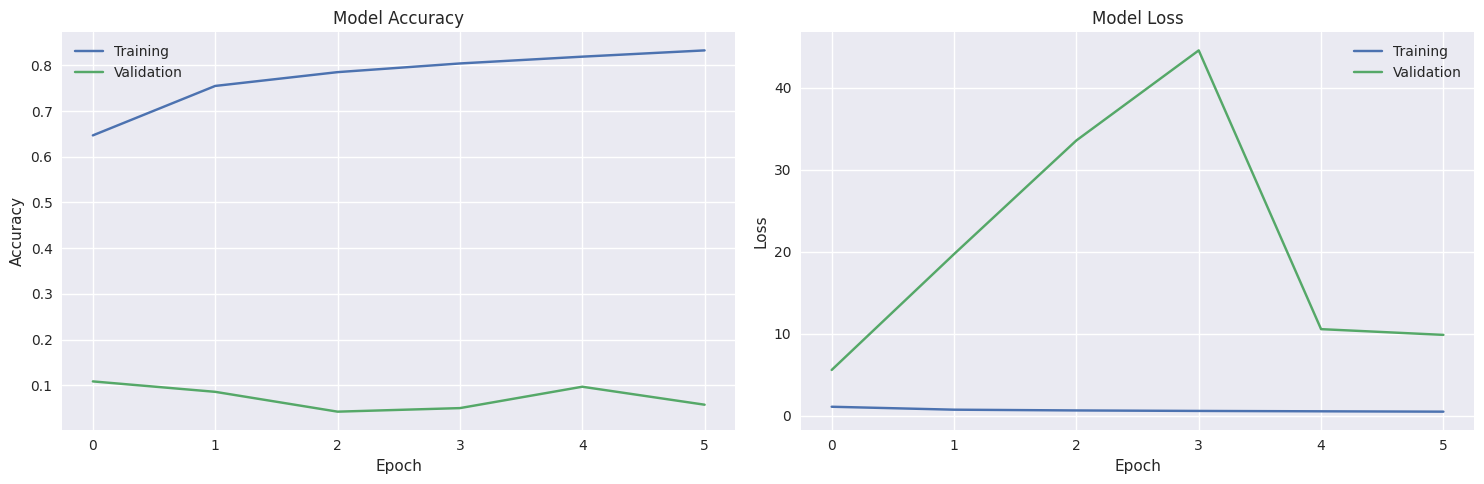

In [13]:
# Plot training curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot accuracy
ax1.plot(history['train_acc'], label='Training')
ax1.plot(history['val_acc'], label='Validation')
ax1.set_title('Model Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()

# Plot loss
ax2.plot(history['train_loss'], label='Training')
ax2.plot(history['val_loss'], label='Validation')
ax2.set_title('Model Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()

plt.tight_layout()
plt.show()